# Example - Optimization Using Reciprocal Radii

### April 2025

This example demonstrates smooth surface transitions during optimization using the "reciprocal_radius" variable. This approach helps design optical systems without initially knowing whether each surface should be concave or convex.

The "reciprocal_radius" is defined as 1/radius (the inverse of the radius of curvature). You define initial conditions using the regular "radius" parameter, but the optimization operates on this proxy variable instead.

While the libary code attempts to handle edge cases, there are limitations. It's best to avoid setting the initial radius to exactly zero (which is physically meaningless) or infinity. If you do create a system with a radius of ±infinity or if you manually set reciprocal_radius to zero, it is possible that the optimization stops prematurely. In this case, just re-run the optimization from where it stopped, using either the same algorithm or a different one.

In [1]:
import logging

import numpy as np

from optiland import analysis, optic, optimization

# Disable the warning "findfont: Font family 'cambria' not found." when running on Linux
logging.getLogger("matplotlib.font_manager").disabled = True

 ## 1. Definition of initial system

 We'll define a simple BK7 plano-concave singlet and optimize it to focus on the focal plane.

 We'll try two optimization approaches:
 - First using the standard "radius" variable
 - Then using the "reciprocal_radius" variable

In [2]:
class Singlet(optic.Optic):
    def __init__(self):
        super().__init__()

        # Define surfaces
        # object plane:
        self.add_surface(index=0, thickness=np.inf)
        # first surface, initially concave:
        self.add_surface(
            index=1, radius=-100, thickness=5, material="BK7", is_stop=True
        )
        # the second surface is flat:
        self.add_surface(index=2, radius=np.inf, thickness=45)
        # image plane:
        self.add_surface(index=3)

        # Define aperture
        self.set_aperture(aperture_type="EPD", value=10.0)

        # Define fields
        self.set_field_type(field_type="angle")
        self.add_field(y=0)
        self.add_field(y=1)
        self.add_field(y=2)

        # Define wavelengths
        # Uncomment the blue and red wavelengths to see chromatic aberration effects
        # self.add_wavelength(value=0.4861)
        self.add_wavelength(value=0.5876, is_primary=True)
        # self.add_wavelength(value=0.6563)

Here's our starting lens configuration:

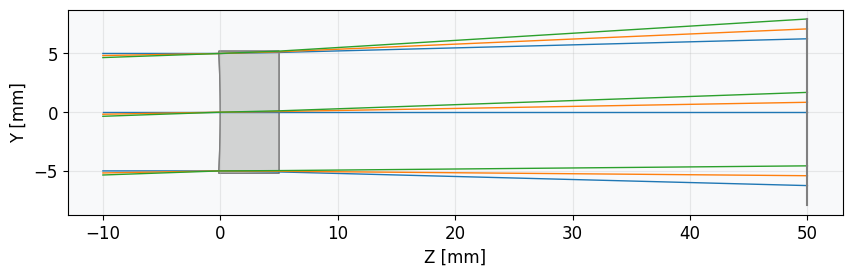

In [3]:
lens = Singlet()
lens.draw()

## 2. Optimization

Now we'll define the optimization problem to achieve focus on a specific plane and minimize the RMS spot size.

In [4]:
problem = optimization.OptimizationProblem()

# Add requirement for spot size
for field in lens.fields.get_field_coords():
    input_data = {
        "optic": lens,
        "Hx": field[0],
        "Hy": field[1],
        "num_rays": 5,
        "wavelength": "all",
        "distribution": "hexapolar",
        "surface_number": 3,
    }
    problem.add_operand(
        operand_type="rms_spot_size", target=0, weight=1, input_data=input_data
    )

### Approach 1: Optimizing with "radius"

First, let's try optimizing using the standard "radius" variable. We don't set limits here because we can't easily specify that radius should be outside an interval (e.g., radius ≥ 10 or radius ≤ -10).

In [5]:
problem.add_variable(lens, "radius", surface_number=1)

Let's check the initial problem configuration:

In [6]:
problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │                69.5755 │                 0 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type   │   Target │ Min. Bound   │ Max. Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ rms spot size  │        0 │              │              │        1 │   4.815 │   4.815 │          33.32 │
│  1 │ rms spot size  │        0 │              │              │        1 │   4.816 │   4.816 │          33.33 │
│  2 │ rms spot size  │        0 │              │              │        1 │   4.817 │   4.817 │          33.35 │
╘════╧════════════════╧══════════╧══════════════╧═════════════

Now we'll run the optimization:

In [7]:
optimizer = optimization.OptimizerGeneric(problem)
res = optimizer.optimize(tol=1e-9)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.95755D+01    |proj g|=  2.79464D+01

At iterate    1    f=  5.63264D+01    |proj g|=  6.26513D+00

At iterate    2    f=  5.47559D+01    |proj g|=  4.71442D+00

At iterate    3    f=  5.18047D+01    |proj g|=  2.39333D+00

At iterate    4    f=  5.01328D+01    |proj g|=  1.42324D+00

At iterate    5    f=  4.87170D+01    |proj g|=  7.97435D-01

At iterate    6    f=  4.76943D+01    |proj g|=  4.57275D-01

At iterate    7    f=  4.69095D+01    |proj g|=  2.59918D-01

At iterate    8    f=  4.63210D+01    |proj g|=  1.48244D-01

At iterate    9    f=  4.58757D+01    |proj g|=  8.44444D-02

At iterate   10    f=  4.55399D+01    |proj g|=  4.81243D-02

At iterate   11    f=  4.52863D+01    |proj g|=  2.74234D-02

At iterate   12    f=  4.50949D+01    |proj g|=  1.56255D-02

At iterate   13    f=  4.4

 This problem is unconstrained.



At iterate   15    f=  4.47590D+01    |proj g|=  2.89049D-03

At iterate   16    f=  4.46969D+01    |proj g|=  1.64633D-03

At iterate   17    f=  4.46500D+01    |proj g|=  9.38626D-04

At iterate   18    f=  4.46146D+01    |proj g|=  5.37170D-04

At iterate   19    f=  4.45877D+01    |proj g|=  3.06954D-04

At iterate   20    f=  4.45673D+01    |proj g|=  1.70530D-04

At iterate   21    f=  4.45527D+01    |proj g|=  1.00186D-04

At iterate   22    f=  4.45408D+01    |proj g|=  5.32907D-05

At iterate   23    f=  4.45329D+01    |proj g|=  3.12639D-05

At iterate   24    f=  4.45161D+01    |proj g|=  1.49216D-05

At iterate   25    f=  4.45123D+01    |proj g|=  7.10550D-06




 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


At iterate   26    f=  4.45123D+01    |proj g|=  7.74500D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1     26     55      2     0     0   7.745D-05   4.451D+01
  F =   44.512321103130290     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


Let's examine the optimization results:

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │                44.5123 │           36.0229 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type   │   Target │ Min. Bound   │ Max. Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ rms spot size  │        0 │              │              │        1 │   3.852 │   3.852 │          33.33 │
│  1 │ rms spot size  │        0 │              │              │        1 │   3.852 │   3.852 │          33.33 │
│  2 │ rms spot size  │        0 │              │              │        1 │   3.852 │   3.852 │          33.33 │
╘════╧════════════════╧══════════╧══════════════╧═════════════

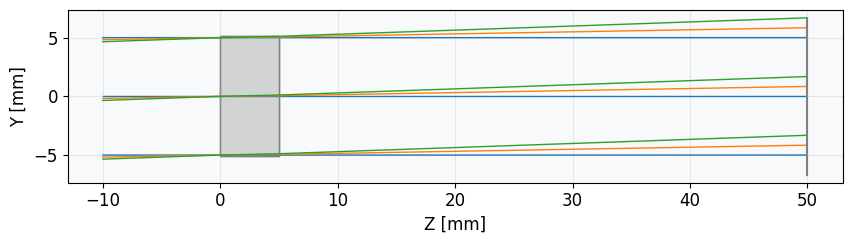

In [8]:
problem.info()
lens.draw()

The optimization struggles to converge to a good solution. This happens because there's no continuous path from a concave to a convex surface when using the "radius" directly.

### Approach 2: Optimizing with "reciprocal_radius"

In [9]:
lens = Singlet()

problem = optimization.OptimizationProblem()

# Add requirement for spot size
for field in lens.fields.get_field_coords():
    input_data = {
        "optic": lens,
        "Hx": field[0],
        "Hy": field[1],
        "num_rays": 5,
        "wavelength": "all",
        "distribution": "hexapolar",
        "surface_number": 3,
    }
    problem.add_operand(
        operand_type="rms_spot_size", target=0, weight=1, input_data=input_data
    )

# Use reciprocal_radius instead of radius for optimization
problem.add_variable(lens, "reciprocal_radius", surface_number=1)

Let's run the optimization:

In [10]:
optimizer = optimization.OptimizerGeneric(problem)
res = optimizer.optimize(tol=1e-9)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.95755D+01    |proj g|=  2.79464D+00

At iterate    1    f=  5.63264D+01    |proj g|=  2.50605D+00

At iterate    2    f=  4.71862D-02    |proj g|=  7.42588D-02

At iterate    3    f=  5.95316D-04    |proj g|=  4.07913D-03

At iterate    4    f=  4.55029D-04    |proj g|=  1.49063D-05

At iterate    5    f=  4.55027D-04    |proj g|=  3.39355D-09

At iterate    6    f=  4.55027D-04    |proj g|=  1.81604D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


And check the results:

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │            0.000455027 │           99.9993 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type   │   Target │ Min. Bound   │ Max. Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ rms spot size  │        0 │              │              │        1 │   0.012 │   0.012 │          32.21 │
│  1 │ rms spot size  │        0 │              │              │        1 │   0.012 │   0.012 │          31.48 │
│  2 │ rms spot size  │        0 │              │              │        1 │   0.013 │   0.013 │          36.31 │
╘════╧════════════════╧══════════╧══════════════╧═════════════

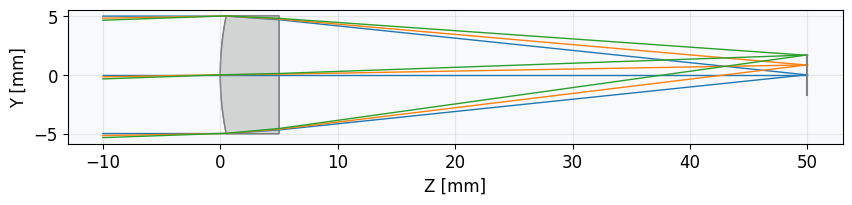

In [11]:
problem.info()
lens.draw()

## Conclusions

- When using the "radius" variable directly, the optimizer often struggles find solutions that require changing from concave to convex or vice versa.
- The "reciprocal_radius" variable allows for smooth transitions between concave and convex surfaces, producing better optimization results in this specific example.
- Initial system conditions are still specified with "radius" in the lens definition, but the optimization works on "reciprocal_radius" internally.
- For fine tuning, after surfaces have reached the correct concavity/convexity, there is no problem in switching back to "radius" for the final optimization steps.
- If the optimization stops prematurely due to edge cases (e.g., initial radius equal to ±infinity), simply re-run the optimization from where it stopped, using either the same algorithm or a different one.